In [30]:
import numpy as np
import pandas as pd
import os
from itertools import groupby
from operator import itemgetter
from aicsimageio.readers import OmeTiffReader
from aicsimageio.writers import OmeTiffWriter
from CustomFunctions import RotateImage
import multiprocessing
from CustomFunctions.PCanimation import interpolate_contour_shapes, mesh_from_bins, interpolate_transitions_by_time
import pickle as pk
from scipy import interpolate
from scipy.spatial import distance
from cmocean import cm
import matplotlib
from matplotlib.animation import FuncAnimation 
import matplotlib.pyplot as plt

def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)


In [31]:
########## find a cell of interest ###########
fl = 'D:/Aaron/Data/Chem_Galv_Combined/'
savedir = fl + 'Data_and_Figs/'
infrsavedir = savedir + 'Inframe_Videos/'

TotalFrame = pd.read_csv(savedir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

#lmax used to generate the shcoeffs
lmax = 10

#get changes in PCs between consecutive frames of a movie
nbins = 11

#first bin PCs
hist1, PC1bins = np.histogram(TotalFrame.PC1, nbins)
hist2, PC2bins = np.histogram(TotalFrame.PC2, nbins)
hist3, PC3bins = np.histogram(TotalFrame.PC3, nbins)
hist4, PC4bins = np.histogram(TotalFrame.PC4, nbins)
TotalFrame['PC1bins'] = np.digitize(TotalFrame.PC1, PC1bins)
TotalFrame['PC2bins'] = np.digitize(TotalFrame.PC2, PC2bins)
TotalFrame['PC3bins'] = np.digitize(TotalFrame.PC3, PC2bins)
TotalFrame['PC4bins'] = np.digitize(TotalFrame.PC4, PC2bins)


#find the length of cell consecutive frames
results = []
for i, cells in TotalFrame.groupby('CellID'):
    cells = cells.sort_values('frame').reset_index(drop = True)
    runs = list()
    #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
    for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
        currentrun = list(map(itemgetter(1), g))
        list.append(runs, currentrun)
    maxrun = max([len(l) for l in runs])
    actualrun = max(runs, key=len, default=[])
    results.append([i, cells.Migration_Mode[0], maxrun, actualrun])
#find
stdf = pd.DataFrame(results, columns = ['CellID','Migration_Mode','length_of_run','actual_run']).sort_values('length_of_run', ascending=False).reset_index(drop=True)
stdf.head(30)

,CellID,Migration_Mode,length_of_run,actual_run
0,20230510_488EGFP-CAAX_640JF646actin-halotag1_c...,Random,52,"[28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35...."
1,20230801_488EGFP-CAAX_640SPY650-DNA_Random6_ce...,Random,41,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,20230727_488EGFP-CAAX_640actin-halotag_Galv2_c...,Galv,41,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,20230509_488EGFP-CAAX_640SPY650-DNA4_cell_11,Random,37,"[15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22...."
4,20230727_488EGFP-CAAX_640actin-halotag_Galv1_c...,Galv,34,"[7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, ..."
5,20230524_488EGFP-CAAX_640SPY650-DNA1_cell_10,Random,34,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19...."
6,20230524_488EGFP-CAAX_640SPY650-DNA4_cell_24,Random,31,"[45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52...."
7,20230524_488EGFP-CAAX_640SPY650-DNA4_cell_36,Random,28,"[43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50...."
8,20230509_488EGFP-CAAX_640SPY650-DNA4_cell_4,Random,28,"[18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25...."
9,20230509_488EGFP-CAAX_640SPY650-DNA2_cell_5,Random,28,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."


In [59]:
#select cell from list above
row = stdf.loc[1]
print(row.CellID)
#get the data related to this run of this cell
data = TotalFrame[(TotalFrame.CellID==row.CellID) & (TotalFrame.frame.isin(row.actual_run))].sort_values('frame').reset_index(drop=True)

20230801_488EGFP-CAAX_640SPY650-DNA_Random6_cell_13


In [6]:
############# reconstruct "in frame" video of cell  without alignment to frame of reference #############
#define directory with the actual images
imdir = 'D:/Aaron/Data/Galvanotaxis/Processed_Data/'

#reconstruct image names
imnames = [row.CellID+'_frame_'+str(int(r+1))+'_raw.tiff' for r in row.actual_run]
#read all the images into a list
imlist = [OmeTiffReader(imdir+i).data for i in imnames]
#get the maximum xyz dimensions of the entire list of images
shapemax = np.max(np.array([s.shape for s in imlist]))
#pad each image to match the same, cubic, 3D array shape
padlist = []
for i, im in enumerate(imlist):
    padlist.append(RotateImage.match_shape(im,list(im.shape[:2])+[shapemax]*3))
#combine all of the expanded images
combinedim = np.concatenate(padlist)
#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
#save the inframe combined image
OmeTiffWriter.save(combinedim.astype(np.uint16), specificdir+'inframe_raw.ome.tiff', dim_order='TCZYX')

In [7]:
############### get animated PCs without interpolating the transitions #############
from CustomFunctions.PCanimation import animate_PCs
import pickle as pk

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)

#get the average of each PC
avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x]].mean().to_numpy()
#open the actual pca file used to analyze this dataset
pca = pk.load(open(savedir+"pca.pkl",'rb'))
#define which PCs to incorporate into the view
whichpcs = [1,2]
#lmax used to generate the shcoeffs
lmax = 10
for r in row.actual_run:
    current = TotalFrame[(TotalFrame.CellID==row.CellID) & (TotalFrame.frame==r)]
    PCs = [current[f'PC{whichpcs[0]}'],current[f'PC{whichpcs[1]}']]
    cursavedir = specificdir + f'Frame_{int(r)}_PC{whichpcs[0]}_and_{whichpcs[1]}_mesh.vtp'
    rotations = current[['Euler_angles_X','Euler_angles_Y','Euler_angles_Z','Width_Rotation_Angle']].values[0]
    animate_PCs(avgpcs,
                whichpcs,
                PCs,
                pca,
                cursavedir,
                lmax,
               rotations,)


In [8]:
############# reconstruct "in frame" video of cell WITH alignment to frame of reference #############


#define directory with the actual images
imdir = 'D:/Aaron/Data/Galvanotaxis/Processed_Data/'

#reconstruct image names
imnames = [row.CellID+'_frame_'+str(int(r))+'_raw.tiff' for r in row.actual_run]
#read all the images into a list
imlist = [OmeTiffReader(imdir+i).data for i in imnames]


#rotate all the raw images so they're facing to the right, like the PCs
if __name__ ==  '__main__':
    pool = multiprocessing.Pool(processes=60)
    results = []
    for i, r in enumerate(row.actual_run):
        current = TotalFrame[(TotalFrame.CellID==row.CellID) & (TotalFrame.frame==r)]
        pool.apply_async(RotateImage.rotate_tiff_mp, args = (
            i,
            imlist[i],
            current.Euler_angles_X.values[0],
            current.Euler_angles_Z.values[0],
            current.Width_Rotation_Angle.values[0],
            True,
            ),
            callback = collect_results)
pool.close()
pool.join()

imlist = [results[x][1] for x in range(len(results))]


#get the maximum xyz dimensions of the entire list of images
shapemax = np.max(np.array([s.shape for s in imlist]))
#pad each image to match the same, cubic, 3D array shape
padlist = []
for i, im in enumerate(imlist):
    padlist.append(RotateImage.match_shape(im,list(im.shape[:2])+[shapemax]*3))
#combine all of the expanded images
combinedim = np.concatenate(padlist)

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
#save the inframe combined image
OmeTiffWriter.save(combinedim, specificdir+'Cell_FoR_raw.ome.tiff', dim_order='TCZYX')

In [9]:
############### get animated PCs WITH interpolated transitions #############


#make the directory to save this combined image
infrsavedir = 'D:/Aaron/Data/Galvanotaxis/Data_and_Figs/Inframe_Videos/'
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)

#get the average of each PC
avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x]].mean().to_numpy()
#open the actual pca file used to analyze this dataset
pca = pk.load(open(savedir+"pca.pkl",'rb'))
#define which PCs to incorporate into the view
whichpcs = [1,2]


#get transition trajectory
bintraj = data[['PC1bins','PC2bins']].to_numpy()


#interpolate the trajectory in the transition space
interarray = interpolate_transitions_by_time(bintraj,)


#get interpolator for PCbins back into PCs
pc1int = interpolate.interp1d(list(range(len(PC1bins))), PC1bins)
pc2int = interpolate.interp1d(list(range(len(PC2bins))), PC2bins)



for i in interarray:
    mesh_from_bins(i,
                    whichpcs,
                    avgpcs,
                    pc1int,
                    pc2int,
                    pca,
                    specificdir,
                    lmax)



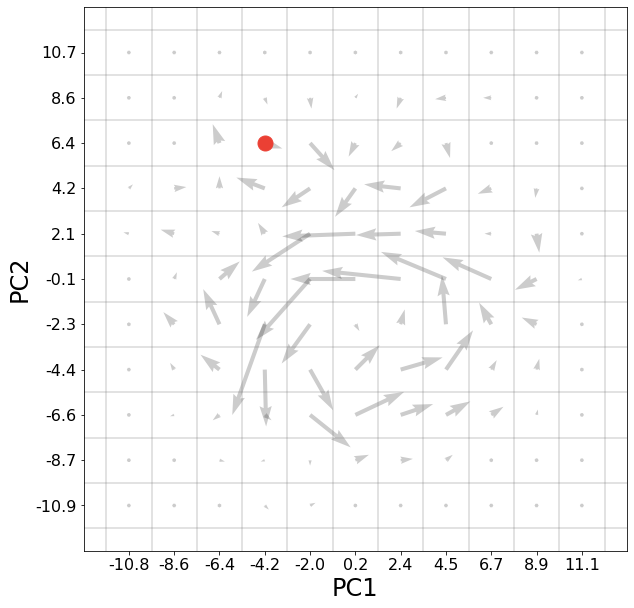

In [209]:
########## animate the PC transition trajectory ##############


#open the vector field relating to this sample
trans_rate_df = pd.read_csv(savedir + 'PC1-PC2_binned_transition_rates_separated.csv', index_col=0)
trans_rate_df = trans_rate_df[trans_rate_df.Migration_Mode == row.Migration_Mode]

nbins = 11

# inverse scale for arrows
scale = 0.0005

#get the interpolated points just in case I haven't calculated them yet
bintraj = data[['PC1bins','PC2bins']].to_numpy()


#interpolate the trajectory in the transition space
interarray = interpolate_transitions_by_time(bintraj, 20)

#make fig
fig, ax = plt.subplots(figsize = (10,10))


#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

for x in range(nbins):
    for y in range(nbins):
        current = trans_rate_df[(trans_rate_df['x'] == x+1) & (trans_rate_df['y'] == y+1)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
#             print(anglecolor)
        ax.quiver((x+1),
                   (y+1), 
                   xcurrent, 
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
                  color = 'black',
                 alpha = 0.2)    
    
    

ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 24)
ax.set_ylabel('PC2', fontsize = 24)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 16)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# ax.set_title(mm, fontsize = 30)


# create a point in the axes
point, = ax.plot(interarray[0,1],interarray[0,2], marker="o", color = '#eb4034', markersize = 15)

# make function for updating point position
def animate(i, interarray):
    point.set_data([interarray[i,1]], [interarray[i,2]])
    return point,

ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                    frames=list(range(len(interarray))), fargs = (interarray,))
plt.show()

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
ani.save(specificdir + '_plotanimation_PC1-PC2.mp4', fps=40, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


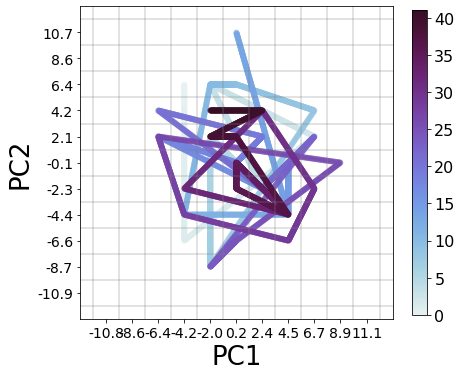

In [60]:
############## look at the entire transition trajectory for this cell #################

# #open interpolated transition data
# inter = pd.read_csv(savedir + 'interpolated_PC1-PC2_transitions.csv', index_col=0)
# interdata = inter[(inter.CellID==row.CellID) & (inter.frame.isin(row.actual_run))]

norm = matplotlib.colors.Normalize()
cmm = cm.dense


fig, ax = plt.subplots(figsize=(7,7))

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

#interpolate along the trajectory so I can plot dots which will represent the color gradient line
px = data.PC1bins.to_numpy()
py = data.PC2bins.to_numpy()
pz = data.frame.to_numpy()
dist = np.nansum(distance.pdist(data[['PC1bins','PC2bins']]))
fx = interpolate.interp1d(np.arange(1,len(px)+1),px)
newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(5*dist)))
fy = interpolate.interp1d(np.arange(1,len(py)+1),py)
newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(5*dist)))
newz = np.arange(0,len(data), len(data)/len(newy))
if len(newz)>len(newy):
    newz = newz[:-1]
#normalize to the colors to the length of the trajectory
norm.autoscale([0,newz.max()])
#plot the actual transitions
ax.scatter(newx,newy, color = cmm(norm(newz)), alpha = 0.25, edgecolors='none')


ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 26)
ax.set_ylabel('PC2', fontsize = 26)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 14)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 14)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)

# #plot the interpolated transitions
# ix = np.append(interdata.from_x.to_numpy(), interdata.to_x.to_numpy()[-1])
# iy = np.append(interdata.from_y.to_numpy(), interdata.to_y.to_numpy()[-1])
# ax.plot(ix, iy, color ='black', alpha=0.2)


cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmm),shrink=0.8)
cb.ax.tick_params(labelsize=16)

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
plt.savefig(specificdir + 'entire_transition_trajectory.png', bbox_inches='tight')

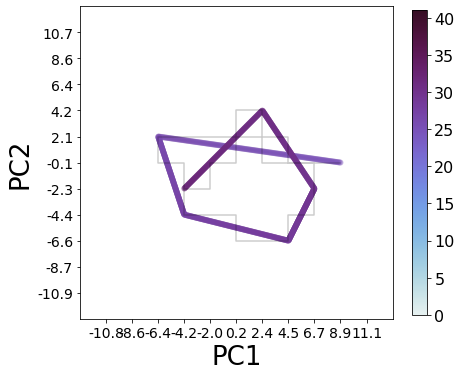

In [205]:
############## look at the SHORTER interpolated transition trajectory for this cell #################

#open interpolated transition data
inter = pd.read_csv(savedir + 'interpolated_PC1-PC2_transitions.csv', index_col=0)
interdata = inter[(inter.CellID==row.CellID) & (inter.frame.isin(row.actual_run))].sort_values(
    ['frame','cumulative_time']).reset_index(drop = True)

norm = matplotlib.colors.Normalize()
cmm = cm.dense


fig, ax = plt.subplots(figsize=(7,7))

# #add "grid lines" first 
# for h in np.linspace(0.5, nbins+0.5, nbins+1):
#     ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
#     ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

datrange = [25,32]
shortdat = data[datrange[0]:datrange[1]].copy()
shortint = pd.concat([interdata.loc[interdata['frame'].isin(range(datrange[0],datrange[1]-1))],
                      pd.DataFrame(interdata[interdata['frame']==datrange[1]-1].iloc[0]).T])

#interpolate along the trajectory so I can plot dots which will represent the color gradient line
px = shortdat.PC1bins.to_numpy()
py = shortdat.PC2bins.to_numpy()
pz = shortdat.frame.to_numpy()
dist = np.nansum(distance.pdist(shortdat[['PC1bins','PC2bins']]))
fx = interpolate.interp1d(np.arange(1,len(px)+1),px)
newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(15*dist)))
fy = interpolate.interp1d(np.arange(1,len(py)+1),py)
newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(15*dist)))
newz = np.arange(datrange[0],datrange[1], len(shortdat)/len(newy))
if len(newz)>len(newy):
    newz = newz[:-1]
#normalize to the colors to the length of the trajectory
norm.autoscale([0,len(data)])
#plot the actual transitions
ax.scatter(newx,newy, color = cmm(norm(newz)), alpha = 0.4, edgecolors='none')


ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 26)
ax.set_ylabel('PC2', fontsize = 26)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 14)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 14)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)

#plot the interpolated transitions
ix = shortint.from_x.to_numpy()#np.append(shortint.from_x.to_numpy(), shortint.to_x.to_numpy()[-1])
iy = shortint.from_y.to_numpy()#np.append(shortint.from_y.to_numpy(), shortint.to_y.to_numpy()[-1])
ax.plot(ix, iy, color ='black', alpha=0.2)


cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmm),shrink=0.8)
cb.ax.tick_params(labelsize=16)

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
plt.savefig(specificdir + 'short_transition_trajectory.png', bbox_inches='tight')

In [204]:
newz

array([0.00000000e+00, 6.02928510e-03, 1.20585702e-02, ...,
       6.98191214e+00, 6.98794143e+00, 6.99397071e+00])

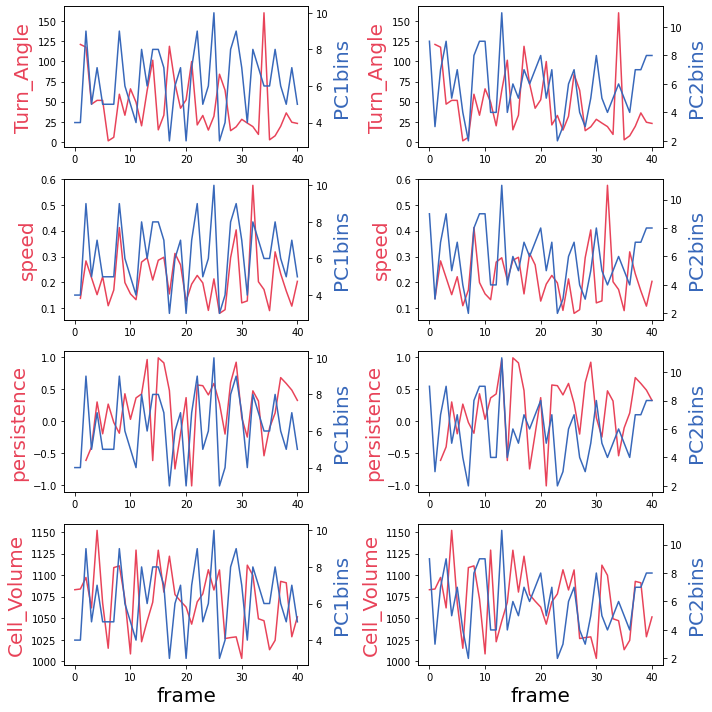

In [217]:
############# plot PC1 and PC2 over time separately ################

colors = ['#e84359','#3868ba']

whichpcs = [1,2]
metlist = [
    'Turn_Angle',
    'speed',
    'persistence',
    'Cell_Volume'
]

fig, axes = plt.subplots(len(metlist),len(whichpcs),figsize=(10,len(metlist)*2.5))
for a, ax in enumerate(axes):
    #plot metric in question
    for i, na in enumerate(ax):
        na.plot(data['frame'].to_numpy(), data[metlist[a]].to_numpy(), color = colors[0])
        na.set_ylabel(metlist[a], color=colors[0], fontsize=20)
        if a == len(axes)-1:
            na.set_xlabel('frame', fontsize = 20)
    #plot PCs in question
    for i, pc in enumerate(whichpcs):
        newax = ax[i].twinx()
        newax.plot(data['frame'].to_numpy(), data[f'PC{pc}bins'].to_numpy(), color = colors[1])
        newax.set_ylabel(f'PC{pc}bins', color=colors[1], fontsize=20)
    
plt.tight_layout()
#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
plt.savefig(specificdir + 'Metrics vs PCs through time.png', bbox_inches='tight')


In [ ]:
############# plot PC1 and PC2 over time separately ################



whichpcs = [1,2]
metlist = [
    'Turn_Angle',
    'speed',
    'persistence',
    'Cell_Volume'
]

fig, axes = plt.subplots(len(metlist),len(whichpcs),figsize=(10,len(metlist)*2.5))
for a, ax in enumerate(axes):
    #plot metric in question
    for i, na in enumerate(ax):
        na.plot(data[metlist[a]].to_numpy(), color = '#f7cf60')
        na.set_ylabel(metlist[a], color='#f7cf60')
        if a == len(axes)-1:
            na.set_xlabel('frame')
    #plot PCs in question
    for i, pc in enumerate(whichpcs):
        newax = ax[i].twinx()
        newax.plot(data[f'PC{pc}bins'].to_numpy(), color = '#58e0ae')
        newax.set_ylabel(f'PC{pc}bins', color='#58e0ae')

In [28]:
from scipy import signal

corr = signal.correlate(data['Turn_Angle'], data['PC2bins'])
lags = signal.correlation_lags(len(data['Turn_Angle']), len(data['PC2bins']))
corr /= np.max(corr)

ValueError: cannot convert float NaN to integer

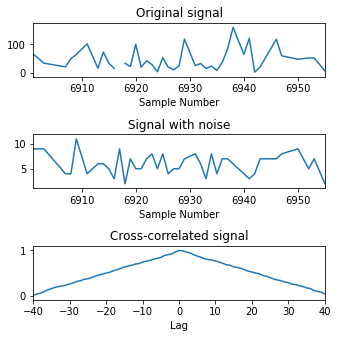

In [29]:
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(4.8, 4.8))
ax_orig.plot(data['Turn_Angle'])
ax_orig.set_title('Original signal')
ax_orig.set_xlabel('Sample Number')
ax_noise.plot(data['PC2bins'])
ax_noise.set_title('Signal with noise')
ax_noise.set_xlabel('Sample Number')
ax_corr.plot(lags, corr)
ax_corr.set_title('Cross-correlated signal')
ax_corr.set_xlabel('Lag')
ax_orig.margins(0, 0.1)
ax_noise.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

In [27]:
lags[40]

0